<a href="https://colab.research.google.com/github/rwagler/Exercise-Digital-Business-and-Platfroms/blob/main/%C3%BC10_ws2425_llm_sentiment_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product Review Sentiment Analysis using Gemma**

Make sure to configure your runtime properly; choose "Python 3" and "T4-GPU" in order to perform computations on GPU.

**Setting up Gemma**

How to: https://ai.google.dev/gemma/docs/setup?hl=de

In [1]:
import os
from google.colab import userdata
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

**Build Gemma for inference**

For more details check: https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/pytorch_gemma.ipynb?hl=de#scrollTo=bMboT70Xop8G

We use kagglehub to download the model as well as our data. Therefore you need to create a kaggle account with an API access token. For use langchain to simplify LLM interactions.

In [2]:
# Install required packages
!pip install -q -U torch immutabledict sentencepiece

In [3]:
! pip install kagglehub --upgrade
! pip install kagglehub[pandas-datasets]

In [4]:
!pip install langchain langchain-community langchainhub

In [5]:
# install gemma --> NOTE: The "installation" is just cloning the repo.
!git clone https://github.com/google/gemma_pytorch.git

Cloning into 'gemma_pytorch'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 244 (delta 100), reused 63 (delta 63), pack-reused 110 (from 1)
Receiving objects: 100% (244/244), 2.17 MiB | 5.15 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [6]:
# Import requierd packages
import os
import kagglehub
from langchain import FewShotPromptTemplate
from langchain.prompts import PromptTemplate

import sys

sys.path.append('gemma_pytorch')

from gemma.config import GemmaConfig, get_model_config
from gemma.model import GemmaForCausalLM
from gemma.tokenizer import Tokenizer
import contextlib
import os
import torch

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

With the following code, we select the Gemma version we like to use. Due to the limited free collab resources, we opt for the relatively small 2b-it version. The MACHINE_TYPE must be set to "cuda" to perform inference on GPU.

In [7]:
# Choose variant and machine type
VARIANT = '2b-it' #@param ['2b', '2b-it', '9b', '9b-it', '27b', '27b-it']
MACHINE_TYPE = 'cuda' #@param ['cuda', 'cpu']

CONFIG = VARIANT[:2]
if CONFIG == '2b':
  CONFIG = '2b-v2'

# Load model weights
weights_dir = kagglehub.model_download(f'google/gemma-2/pyTorch/gemma-2-{VARIANT}')

In [8]:
# Some checks to ensure the model weights are loaded properly
# Ensure that the tokenizer is present
tokenizer_path = os.path.join(weights_dir, 'tokenizer.model')
assert os.path.isfile(tokenizer_path), 'Tokenizer not found!'

# Ensure that the checkpoint is present
ckpt_path = os.path.join(weights_dir, f'model.ckpt')
assert os.path.isfile(ckpt_path), 'PyTorch checkpoint not found!'

In [9]:
# Set up model config.
model_config = get_model_config(CONFIG)
model_config.tokenizer = tokenizer_path
model_config.quant = 'quant' in VARIANT

# Instantiate the model and load the weights.
torch.set_default_dtype(model_config.get_dtype())
device = torch.device(MACHINE_TYPE)
model = GemmaForCausalLM(model_config)
model.load_weights(ckpt_path)
model = model.to(device).eval()

Load product review dataset

Link to dataset: https://www.kaggle.com/datasets/mahmudulhaqueshawon/amazon-product-**reviews**

In [10]:
# Download the dataset directly into a data frame using kaggle hub
df = kagglehub.load_dataset(
    kagglehub.KaggleDatasetAdapter.PANDAS,
    "mahmudulhaqueshawon/amazon-product-reviews",
    "amazon.csv",
)

100%|██████████| 1.27M/1.27M [00:00<00:00, 84.6MB/s]

Extracting zip of amazon.csv...


In [11]:
df = df[:200] # Use only the first 200 rows from the dataframe

In [12]:
df.head() # View df

,Text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


In [13]:
df['label'].value_counts() # Check the number of positive and negative reviews

,count
label,
1,120
0,80


In [14]:
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=False) # Shuffle df
test = shuffled_df.iloc[:70] # Select 70 samples for testing
other = shuffled_df.iloc[70:] # Store the remaining samples in a seperate df
other.head(20)

,index,Text,label
70,51,What can I say that you probably don't already...,1
71,127,Didn't like this game. Can't see what all the ...,0
72,162,great app highly recommend very easy to use or...,1
73,41,"Very fun and challenges you, I always try and ...",1
74,118,Too technical for me. I got so upset that I re...,0
75,113,This app is on of the worst if have ever used....,0
76,26,this is the game to get. those other bad comme...,1
77,139,I thought this was going to be the best game e...,0
78,100,it keeps telling me &quot;my payment method ne...,0
79,111,The game was fun at first. Then when you would...,0


In [15]:
test['label'].value_counts() # Check the number of positive and negative reviews in the test set

,count
label,
1,39
0,31


In [16]:
few_shot_examples = pd.concat([other[2:5],other[4:5]], axis = 0, ignore_index= True) # Extract 4 examples for the few-shot learning
few_shot_examples.head()

,index,Text,label
0,162,great app highly recommend very easy to use or...,1
1,41,"Very fun and challenges you, I always try and ...",1
2,118,Too technical for me. I got so upset that I re...,0
3,118,Too technical for me. I got so upset that I re...,0


**Setting up LLM**

Once the model is appropriately instanced, a test dataset is defined and some examples for the few-shot learning are selected, we can start with the prompting.

In [17]:
# Construt few-shot prompt
examples = [                                  # Define few show examples
    {"prompt": few_shot_examples['Text'][0],
     "target": few_shot_examples['label'][0]},
    {"prompt": few_shot_examples['Text'][1],
     "target": few_shot_examples['label'][1]},
    {"prompt": few_shot_examples['Text'][2],
     "target": few_shot_examples['label'][2]},
    {"prompt": few_shot_examples['Text'][3],
     "target": few_shot_examples['label'][3]}
]
# Define templatee
example_template = """
User: {prompt}
AI: {target}
"""
example_prompt = PromptTemplate(
    input_variables=['prompt', 'target'],
    template=example_template
)
# Define pre- and suffix
prefix = """You are a helpful assistant, which classifies product reviews.
If a review is positive about the product, you retrun a 1.
If the review is negative you return a 0. Return only the correct number,
no additional output.
Here are some examples:
"""
suffix = """
User: {prompt}
AI: """
# Few-shot template
few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["prompt"],
    example_separator="\n\n"
)

The example above uses a prefix which is equivalent to the "System-Prompt" from Open AI. When defining the prompt, it recommended to have a look to the docs of your model to understand the syntax and supported role.

In [18]:
# Defining a parser to parse to output of the llm properly
def advanced_output_parser(text):
    index = text.find("User:")
    if index != -1:
      try: resp = int(text[:index])
      except: resp = -1
      return resp
    else:
        return int(-1)

We need to define a parser which ensures the putput of the LLM is formatted properly, as the used model is not fine-tuned and tends to hallucinate.

In [19]:
# Call the model for a specific example form the test set, only the value for the "Text" col is fed into the model.
# Change the row index to use another example from the test set, e.g. ['Text'][7] for the 8th row (remember that Python starts counting at 0, not 1)
prompt = test['Text'][17]
response = model.generate(
    few_shot_prompt_template.format(prompt=prompt),
    device=device,
    output_len=128,
)

In [20]:
# Print the parsed result, if it shows -1, the model has hallucinated, and the parser could not format the output correctly.
# Try to rerun the example or choose another example.
print(advanced_output_parser(response))

-1


In [21]:
test.head(20) # View the test data with labels and compare with the models output above

,index,Text,label
0,95,"I'll admit, I'm late to the game for getting t...",1
1,15,This is super fun though a little frustrating ...,1
2,30,This is very popular game I've been hearing fo...,1
3,158,"Free and fun, what could be better? I enjoy p...",1
4,128,Don't like it really boring game. probably won...,0
5,115,this game was hard to download.it would be eas...,0
6,69,yes ads are annoying but its FREE! I love to l...,1
7,170,It is really fun to play and increase skills a...,1
8,174,My grandson has this and I like to play on his...,1
9,45,"Very high quality for a game. Fast, and crysta...",1


Test all 70 examples form the test set

In [22]:
results = test
predictions = []

for i in range(len(test)):    # Loop over all examples from the test set and store the results as separate of a df
  prompt = test['Text'][i]
  response = model.generate(
      few_shot_prompt_template.format(prompt=prompt),
      device=device,
      output_len=128,
      )
  predictions.append(advanced_output_parser(response))

results['predictions'] = predictions

In [23]:
results.head() # View the results

,index,Text,label,predictions
0,95,"I'll admit, I'm late to the game for getting t...",1,-1
1,15,This is super fun though a little frustrating ...,1,-1
2,30,This is very popular game I've been hearing fo...,1,-1
3,158,"Free and fun, what could be better? I enjoy p...",1,-1
4,128,Don't like it really boring game. probably won...,0,-1


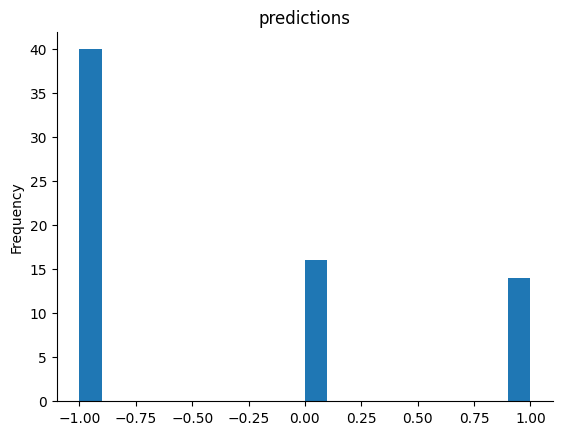

In [24]:
# @title Predictions

from matplotlib import pyplot as plt
results['predictions'].plot(kind='hist', bins=20, title='predictions')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [25]:
# Define a function to calculate the accuracy of the LLM using the labels from the original dataset. Please note that hallucinations (-1) are excluded from the calculation.
def calculate_average_difference(df):
    valid_rows = df[(df['predictions'] == 0) | (df['predictions'] == 1)]
    valid_rows['difference'] = valid_rows['predictions'] - valid_rows['label']
    if not valid_rows.empty:
        average_difference = valid_rows['difference'].mean()
    else:
        average_difference = None

    return average_difference

In [26]:
# Calculate the accuracy of the LLM
print('accuracy: ', (1- calculate_average_difference(results)))

accuracy:  1.0


Please note that this example is built for the  purpose of showing the core idea of using LLMs for sentiment analysis. It's not a productive example or at least focused on performance.  